### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import os
import logging
import yaml
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import boston_housing
from keras.regularizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


### IMPORT CONFIG

In [2]:
with open("../config/keras_config.yaml", 'r') as stream:
    kerasgrid_config = yaml.safe_load(stream)

In [3]:
def convert_yaml2grid(yaml):
    
    grid = [tuple([tuple(yaml[k1][k2]) for k2 in list(yaml[k1])]) for k1 in list(yaml)]
    
    return grid

def return_empty_list():
    
    return []

In [4]:
kerasgrid_config['grid_params']['network'] = convert_yaml2grid(kerasgrid_config['grid_params']['network'])

### SETUP LOGGER

In [5]:
logging._warn_preinit_stderr = 0
logger = logging.getLogger()
# create file handler that logs debug and higher level messages
_file_path = '../logs/'
_file_name = pd.Timestamp.utcnow().strftime('%Y%m%d_%H%M_')+'notebook.log'
fh = logging.FileHandler(_file_path + _file_name)
fh.setLevel(logging.INFO)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(ch)
logger.addHandler(fh)
logger.setLevel(logging.INFO)

### AUXILIARY FUNCTIONS

In [6]:
def create_model(input_layer_shape=None,
                 network=((10, 'relu', 0.1),(1,'linear',0)), 
                 optimizer='adam'):
    n = len(network)
    model = Sequential()
    model.add(Dropout(network[0][2]))
    model.add(Dense(network[0][0], input_dim=input_layer_shape, activation=network[0][1]))
    if n>1:
        for _layer in range(1,n):
            model.add(Dropout(network[_layer][2]))
            model.add(Dense(network[_layer][0], 
                            activation=network[_layer][1],
                            kernel_regularizer=l1_l2(network[_layer][3],network[_layer][4])))

    model.compile(loss='mae', optimizer=optimizer, metrics=['accuracy']) 
    return model


def generate_callbacks():
    
    early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, 
                      verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                             verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
    
    return [early, reducelr]

### MAIN CLASS OBJECT

In [7]:
class gridSearchKerasNN(object):
    
    def __init__(self, config=None):
        
        if config is None:
            logger.info('No default config dictionaty was loaded')
        else:
            self.set_config_params(config)
            self._config = config
            logger.info('Default config dictionaty was initialized')
            
        self._generate_callbacks = return_empty_list
        
        return
    
    def set_grid_params(self, params):
        
        self._grid_params = params
        
        return
    
    def set_callbacks(self, callbacks_function):
        
        self._generate_callbacks = callbacks_function
        
        return
    
    def set_cv_params(self, params):
        
        self._cv_params = params
        
        return
    
    def set_config_params(self, config=None):
        
        if config is None:
            logger.info('Default config parameters will be used')
        else:
            self.set_grid_params(config['grid_params'])
            self.set_cv_params(config['cv_params'])
            logger.info('Passed config parameters will be used')
        
        return
    
    def initialize_network(self, network_function):
        
        self._model = KerasRegressor(build_fn=network_function)
        
        return
    
    def initialize_grid(self):
        
        _cv = self._cv_params['cv']
        _verb = self._cv_params['verb']
        _scoring = self._cv_params['scoring']
        _n_jobs = self._cv_params['n_jobs']
        
        self._grid = GridSearchCV(estimator=self._model, 
                                  param_grid=self._grid_params, 
                                  scoring=_scoring, 
                                  cv=_cv, 
                                  verbose = _verb,
                                  n_jobs = _n_jobs)
        logger.info('GridSearchCV object is instantiated')
        
        return
    
    def fit(self, X_train, y_train, X_test, y_test):
        
        self._grid_params['input_layer_shape'] = [X_train.shape[1]]
        
        self._grid_results = self._grid.fit(X_train, y_train, 
                                     validation_data=(X_test,y_test), 
                                     callbacks=self._generate_callbacks(), 
                                     verbose=0)
        
        print("Best: %f using %s" % (self._grid_results.best_score_, self._grid_results.best_params_))
        
        return
    
    def predict(self, X_test, y_test):
        
        y_pred = self._grid.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        logger.info('MAE on test: {:.2f}, RMSE on test: {:.2f}'.format(mae, rmse))
        
        return
    
    def load(self):
        
        return
    
    def dump(self):
        
        return

### EXAMPLE: BOSTON HOUSING DATASET

In [8]:
# PREPROCESSING

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [9]:
%%time
# TRAIN
gridKeras = gridSearchKerasNN(kerasgrid_config)
#gridKeras.set_callbacks(generate_callbacks)
gridKeras.initialize_network(create_model)
gridKeras.initialize_grid()
gridKeras.fit(X_train, y_train, X_test, y_test)

2020-01-03 09:53:24,685 - INFO - Passed config parameters will be used
2020-01-03 09:53:24,686 - INFO - Default config dictionaty was initialized
2020-01-03 09:53:24,687 - INFO - GridSearchCV object is instantiated
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 6 folds for each of 48 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   32.0s
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
2020-01-03 09:54:40,367 - WARNING - From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Best: -2.489936 using {'batch_size': 32, 'epochs': 100, 'input_layer_shape': 13, 'network': ((20, 'relu', 0.1, 0, 0), (10, 'relu', 0.1, 0, 0), (1, 'linear', 0, 0, 0)), 'optimizer': 'sgd'}
Wall time: 1min 18s


In [10]:
# TEST
gridKeras.predict(X_test,y_test)

2020-01-03 09:54:50,185 - INFO - MAE on test: 2.76, RMSE on test: 4.02


### PLOT

In [15]:
gridKeras._grid_results.best_params_

{'batch_size': 32,
 'epochs': 150,
 'input_layer_shape': 13,
 'network': ((20, 'relu', 0.1, 0, 0),
  (10, 'relu', 0.1, 0, 0),
  (1, 'linear', 0, 0, 0)),
 'optimizer': 'sgd'}

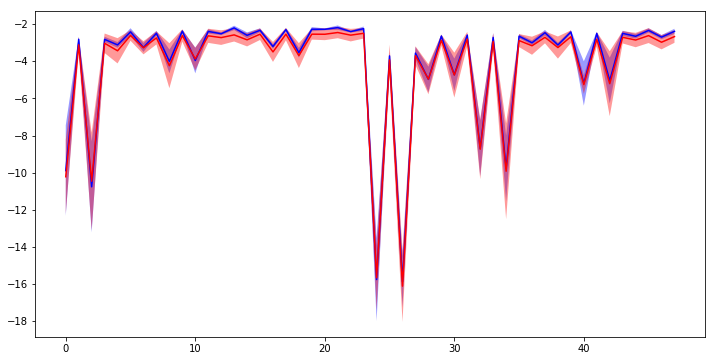

In [16]:
_mean_train = gridKeras._grid_results.cv_results_['mean_train_score']
_lower_train = gridKeras._grid_results.cv_results_['mean_train_score'] - gridKeras._grid_results.cv_results_['std_train_score']
_upper_train = gridKeras._grid_results.cv_results_['mean_train_score'] + gridKeras._grid_results.cv_results_['std_train_score']

_mean_test = gridKeras._grid_results.cv_results_['mean_test_score']
_lower_test = gridKeras._grid_results.cv_results_['mean_test_score'] - gridKeras._grid_results.cv_results_['std_test_score']
_upper_test = gridKeras._grid_results.cv_results_['mean_test_score'] + gridKeras._grid_results.cv_results_['std_test_score']

plt.figure(figsize=(12,6))
plt.fill_between(range(len(_lower_train)), _lower_train, _upper_train, facecolor='blue', alpha=0.4)
plt.plot(_mean_train, color='blue')

plt.fill_between(range(len(_lower_test)), _lower_test, _upper_test, facecolor='red', alpha=0.4)
plt.plot(_mean_test, color='red')

plt.show()
